In [22]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sklearn
import matplotlib.pyplot as plt
import math
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline

In [23]:
## load in the preprocessed data and the sale prices for training data
data = pd.read_csv('one_hot.csv')
data.set_index('Id', inplace=True)

In [24]:
# import raw training data and get log of prices
train_raw = pd.read_csv('train.csv')
train_raw.set_index('Id', inplace=True)
logprices = np.log10(train_raw.SalePrice)

In [25]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)
columns = list(data.columns)

/Users/bhalbur/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [26]:
scaled = pd.DataFrame(data_scaled, columns=columns)
scaled.index +=1
train = scaled.loc[1:1460,]
test = scaled.loc[1461:2919,]

In [27]:
outliers = list(train_raw[(train_raw['GrLivArea']>4000) & (train_raw['SalePrice']<300000)].index)
outliers

[524, 1299]

In [28]:
##Drop some of the correlated and categorical variables
dropcols = ['MSSubClass','MasVnrArea','TotalBsmtSF','LowQualFinSF','GrLivArea','TotRmsAbvGrd']
nonecols = ['BsmtQual_None','BsmtCond_None','BsmtFinType1_None', 'GarageType_None', 'GarageFinish_None', 'GarageQual_None', 'GarageCond_None']
droprows = outliers
trim = scaled.drop(columns=dropcols)
trim = trim.drop(columns=nonecols)
trim = trim.drop(droprows)
trimprices = logprices.drop(droprows)

R squared: -5.1835527305940845
Root Mean Squared Error: 17486.612969057936


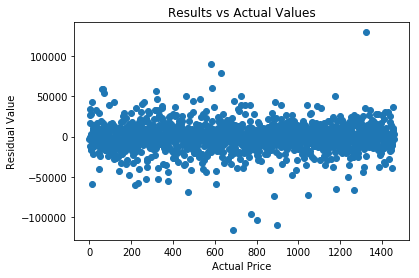

In [29]:
train = trim.loc[1:1460,]
test = trim.loc[1461:2919,]
linreg = LinearRegression()
linreg.fit(train, trimprices)
yhat = np.power(10, linreg.predict(train))
y = np.power(10, trimprices)
plt.scatter(range(len(y)),yhat-y)
plt.xlabel('Actual Price')
plt.ylabel('Residual Value')
plt.title('Results vs Actual Values')
print("R squared:",linreg.score(train, y, sample_weight=None))
RMSE = math.sqrt(mean_squared_error(y, yhat))
print("Root Mean Squared Error:",RMSE)

In [30]:
results = pd.DataFrame({'Id':train.index, 'Residual':y-yhat})
results.set_index('Id', inplace=True)
results.head()
large_resid = list(results[(results['Residual']>75000) | (results['Residual']<-75000)].index)
large_resid

[582, 633, 689, 775, 804, 899, 1325]

In [31]:
##SECOND ITERATION - dropping ID's with large residual values
droprows = large_resid
trim = trim.drop(droprows)
trimprices = trimprices.drop(droprows)

R squared: -5.377165027629383
Root Mean Squared Error: 15831.52900831997


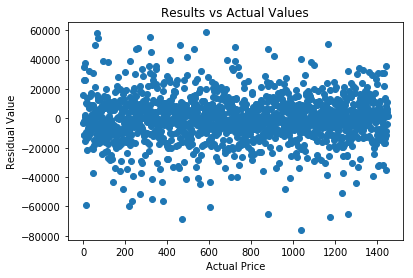

In [32]:
train = trim.loc[1:1460,]
test = trim.loc[1461:2919,]
linreg = LinearRegression()
linreg.fit(train, trimprices)
yhat = np.power(10, linreg.predict(train))
y = np.power(10, trimprices)
plt.scatter(range(len(y)),yhat-y)
plt.xlabel('Actual Price')
plt.ylabel('Residual Value')
plt.title('Results vs Actual Values')
print("R squared:",linreg.score(train, y, sample_weight=None))
RMSE = math.sqrt(mean_squared_error(y, yhat))
print("Root Mean Squared Error:",RMSE)

R squared: 0.9438562826642359
Root Mean Squared Error: 0.04073415299597718


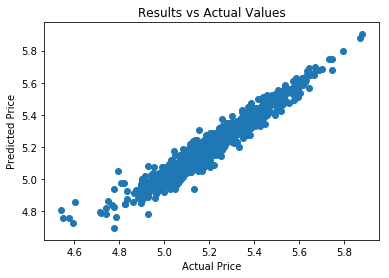

In [13]:
yhat_linreg = linreg.predict(train)
y = trimprices
plt.scatter(y, yhat_linreg)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Results vs Actual Values')
print("R squared:",linreg.score(train, y, sample_weight=None))
RMSE = math.sqrt(mean_squared_error(y, yhat_linreg))
print("Root Mean Squared Error:",RMSE)

R squared: 0.9559436027525757
Root Mean Squared Error: 0.03608382748356725


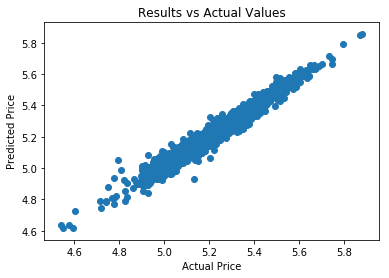

In [14]:
boost = GradientBoostingRegressor()
boost.fit(train, trimprices, sample_weight=None ,monitor=None)
yhat_boost = boost.predict(train)
plt.scatter(y, yhat_boost)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Results vs Actual Values')
print("R squared:",boost.score(train, y, sample_weight=None))
RMSE = math.sqrt(mean_squared_error(y, yhat_boost))
print("Root Mean Squared Error:",RMSE)

R squared: 0.8973112445989557
Root Mean Squared Error: 0.055089591648037825


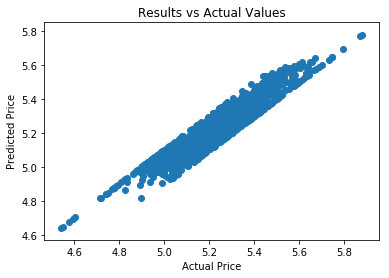

In [15]:
svr = SVR(gamma='scale', C=1, epsilon=.1)
svr.fit(train, trimprices)
y = trimprices
yhat_svr = svr.predict(train)
plt.scatter(y, yhat_svr)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Results vs Actual Values')
print("R squared:",svr.score(train, y, sample_weight=None))
RMSE = math.sqrt(mean_squared_error(y, yhat_svr))
print("Root Mean Squared Error:",RMSE)

Text(0.5, 1.0, 'Results vs Actual Values')

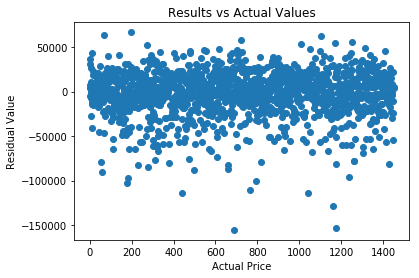

In [16]:
yhat = np.power(10, yhat_svr)
y10 = np.power(10, trimprices)
plt.scatter(range(len(y10)),yhat-y10)
plt.xlabel('Actual Price')
plt.ylabel('Residual Value')
plt.title('Results vs Actual Values')

Root Mean Squared Error: 0.03737831901285112


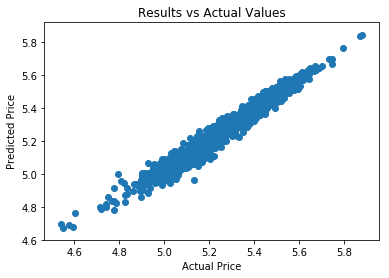

In [17]:
yhat_test_combined = (yhat_linreg + yhat_svr + yhat_boost)/3
plt.scatter(y, yhat_test_combined)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Results vs Actual Values')
RMSE = math.sqrt(mean_squared_error(y, yhat_test_combined))
print("Root Mean Squared Error:",RMSE)

In [18]:
yhat_sub_boost = boost.predict(test)
yhat_sub_svr = svr.predict(test)
yhat_sub_linreg = linreg.predict(test)

In [99]:
submit_yhat= yhat_sub_svr

In [19]:
submit_yhat = (yhat_sub_boost + yhat_sub_svr + yhat_sub_linreg)/3

## Export to .csv for uploading

In [20]:
submission = pd.DataFrame({'Id':test.index, 'SalePrice': np.power(10, submit_yhat)})
submission.set_index('Id', inplace=True)
print(submission.head())
timestamp = datetime.now().strftime('%m-%d-%H-%M-%S')

      SalePrice
Id             
1461 124,039.74
1462 155,325.13
1463 191,007.44
1464 205,642.36
1465 200,084.31


In [21]:
submission.to_csv(f'submission_files/Sub{timestamp}.csv')